In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# the module that has all the methods for handling the data
import resources.featuredata as featuredata

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from myst_nb import glue

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette
bassin_pallette = featuredata.bassin_pallette


# border and row shading fro tables
a_color = "saddlebrown"
table_row = "saddlebrown"

## !! Begin Note book variables !!
# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/survey_areas/aare_scaled.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the Aare (aare) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'all', 'name':"Alle Erhebungsgebiete", 'level':'all'}

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'river_bassin'

# identify the lakes of interest for the survey area
# lakes_of_interest = ["neuenburgersee", "thunersee", "bielersee", "brienzersee"]

# !! End note book variables !!

## data
# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# code definitions
dxCodes = pd.read_csv("resources/codes_with_group_names")
dxCodes.set_index("code", inplace=True)

# columns that need to be renamed. Setting the language will automatically
# change column names, code descriptions and chart annotations
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
# !this is the feature data!
fd = fdx.feature_data

# the period data is all the data that was collected
# during the same period from all the other locations
# not included in the feature data for a survey area
# or river bassin the parent and feature level are the
# the same.
period_kwargs = {
    "period_data": fdx.period_data,
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_feature['slug'],
    "parent_level": this_feature['level'],
    "period_name": top,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# the rivers are considered separately
# select only the results from rivers
fd_kwargs.update({"water_type":"r"})
fdr = featuredata.Components(**fd_kwargs)
fdr.makeFeatureData()
fdr.adjustForLanguage()
fdr.locationSampleTotals()
fdr.makeDailyTotalSummary()
fdr.materialSummary()
fdr.mostCommon()

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    **{"dfBeaches":dfBeaches}
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()
admin_r_details = featuredata.AdministrativeSummary(data=fdr.feature_data, dims_data=dfDims, label=this_feature["name"], feature_component=this_level, date_range=start_end, **{"dfBeaches":dfBeaches})

admin_kwargs.update({"data":fdr.feature_data})
admin_r_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_r_summary = admin_r_details.summaryObject()

(gisoutput)=
# GIS output

In [2]:
# this gets all the data for the project
land_use_kwargs = {
    "data": period_data.period_data,
    "index_column":"loc_date",
    "these_features": this_feature['slug'],
    "feature_level":this_level   
}

# the landuse profile of the project
project_profile = featuredata.LandUseProfile(**land_use_kwargs).byIndexColumn()

# update the kwargs for the feature data
land_use_kwargs.update({"data":fdx.feature_data})

# build the landuse profile of the feature
feature_profile = featuredata.LandUseProfile(**land_use_kwargs)

# this is the component features of the report
feature_landuse = feature_profile.featureOfInterest()

### Gesamtergebnisse nach Erhebungsgebiet

In [3]:
# the dimensional data
dims_table = admin_details.dimensionalSummary()

# a method to update the place names from slug to proper name
name_map = featuredata.river_basin_de

# the order in which they are charted
name_order = list(name_map.keys())

# sort by quantity
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)

# translating column names
dims_table.rename(columns=featuredata.dims_table_columns_de, inplace=True)

# the values in these columns need formating to swiss spec
thousands_separated = ["Fläche (m2)", "Länge (m)", "Erhebungen", "Objekte (St.)"]
replace_decimal = ["Plastik (Kg)", "Gesamtgewicht (Kg)"]
dims_table["Plastik (Kg)"] = dims_table["Plastik (Kg)"]/1000
dims_table.reset_index(inplace=True)
dims_table["river_bassin"] = dims_table.river_bassin.map(lambda x: featuredata.updatePlaceNames(x=x, a_map=name_map))

dims_table

,river_bassin,Gesamtgewicht (Kg),Plastik (Kg),Fläche (m2),Länge (m),Erhebungen,Objekte (St.)
0,Alle Erhebungsgebiete,305.507,94.213346,96616.35,19722.0,386.0,54744.0
1,Rhone,151.309,45.967375,25986.25,4911.0,106.0,28454.0
2,Aare,71.976,31.448170,37017.80,7971.0,140.0,13847.0
3,Linth,35.961,12.772621,25637.80,5323.0,112.0,9412.0
4,Ticino,46.261,4.025180,7974.50,1517.0,28.0,3031.0


## Erhebungsergebnisse für alle Objekte

Verteilung der Erhebungsergebnisse. Die Werte werden als Anzahl der identifizierten Abfallobjekte pro 100 Meter (p/100 m) dargestellt. 

### The sample location layer

The median sample total in p/100 m for each location is figured and the lat, lon are attached. Included identifying information:

1. city
2. survey area
3. quantity
4. number of samples

In [4]:
# the sample totals of the parent feautre
dx = period_data.parentSampleTotals(parent=False)

# sample totals of the feature data
sample_totals = fdx.sample_totals
these_beaches = admin_details.df_beaches.loc[sample_totals.location.unique()]

# for each location or level sum the quantity and get the median survey value
agg_columns = {"quantity": "sum", "p/100 m": "median", "loc_date": "nunique"}
columns = ["river_bassin", "location"]

location_layer = sample_totals.groupby(columns, as_index=False).agg(agg_columns)

lat_lon = these_beaches[["latitude", "longitude"]]
cities = these_beaches["city"]

location_layer["lat"] = location_layer.location.map(lambda x: lat_lon.loc[x, "latitude"])
location_layer["lon"] = location_layer.location.map(lambda x: lat_lon.loc[x, "longitude"])
location_layer["city"] = location_layer.location.map(lambda x: cities.loc[x])
location_layer['samples'] = location_layer.loc_date

location_layer.drop("loc_date", axis=1, inplace=True)

location_layer.to_csv("resources/output/gis/location_layer.csv", index=False)

location_layer.head()

,river_bassin,location,quantity,p/100 m,lat,lon,city,samples
0,aare,aare-limmatspitz,70,60.0,47.501060,8.237371,Gebenstorf,1
1,aare,aare-port,99,253.0,47.116170,7.269550,Port,1
2,aare,aare-solothurn-lido-strand,27,244.0,47.196949,7.521643,Solothurn,1
3,aare,aare_bern_gerberm,134,363.0,46.989363,7.452098,Bern,1
4,aare,aare_bern_scheurerk,4,12.0,46.970967,7.452586,Bern,1


### The survey area layer

The survey area layer is the aggregate of the sample totals grouped by survey area. The latitude and longitude of the point is 
determined by the first record with a matching survey area. The attributes are assigned to a polygon that includes all the municipalities
in the survey area. The median sample total for the survey area is reported as well as

1. quantity
2. number of samples
3. survey area label

In [49]:
surveyarea_layer = sample_totals.groupby("river_bassin", as_index=False).agg(agg_columns)

rbassins =  these_beaches[["river_bassin", "latitude", "longitude"]].drop_duplicates("river_bassin")
rbassins.set_index("river_bassin", inplace=True, drop=True)

surveyarea_layer["lat"] = surveyarea_layer.river_bassin.map(lambda x: rbassins.loc[x, "latitude"])
surveyarea_layer["lon"] = surveyarea_layer.river_bassin.map(lambda x: rbassins.loc[x, "longitude"])
surveyarea_layer["samples"] = surveyarea_layer.loc_date

surveyarea_layer.drop("loc_date", axis=1, inplace=True)

surveyarea_layer.to_csv("resources/output/gis/surveyarea_layer.csv", index=False)

surveyarea_layer.head()

,river_bassin,quantity,p/100 m,lat,lon,samples
0,aare,13847,143.5,47.501060,8.237371,140
1,linth,9412,131.5,47.220989,8.940365,112
2,rhone,28454,442.5,46.447216,6.859612,106
3,ticino,3031,160.5,46.153882,8.768480,28


### The water feature layer

The water feature layer is the aggregate of the sample totals grouped by water feature area.

In [6]:
water_feature_map = admin_details.makeLocationFeatureMap()
water_feature_layer = sample_totals.copy()
water_feature_layer["water_feature"] = water_feature_layer.location.map(lambda x: water_feature_map.loc[x])

wfeatures =  these_beaches[["water_name_slug", "latitude", "longitude"]].drop_duplicates("water_name_slug")
wfeatures.set_index("water_name_slug", inplace=True, drop=True)

water_feature_layer = water_feature_layer.groupby("water_feature", as_index=False).agg(agg_columns)
water_feature_layer["lat"] = water_feature_layer.water_feature.map(lambda x: wfeatures.loc[x, "latitude"])
water_feature_layer["lon"] = water_feature_layer.water_feature.map(lambda x: wfeatures.loc[x, "longitude"])
water_feature_layer["samples"] = water_feature_layer.loc_date

water_feature_layer.drop("loc_date", axis=1, inplace=True)

water_feature_layer.to_csv("resources/output/gis/water_feature_layer.csv", index=False)

water_feature_layer.head()

,water_feature,quantity,p/100 m,lat,lon,samples
0,aare,478,49.0,47.501060,8.237371,15
1,aarenidau-buren-kanal,155,102.0,47.116170,7.269550,3
2,bielersee,4477,340.0,47.038398,7.108311,38
3,brienzersee,974,334.0,46.690283,7.898592,5
4,cassarate,54,75.0,46.002411,8.961477,1


### The municipal area layer

The municipal layer is the aggregate of the sample totals grouped by city. The latitude and longitude of the point is 
determined by the first record with a matching city. The attributes are assigned to a polygon of that city. The median sample total for the survey area is reported as well as
111
1. quantity
2. number of samples
3. survey area label

In [7]:
# calling the components class on updated keywords
# aggregatest to the city level

fd_kwargs_city ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": "city", 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}



fdc = featuredata.Components(**fd_kwargs_city)

fdc.adjustForLanguage()
fdc.makeFeatureData()
fdc.locationSampleTotals()
fdc.makeDailyTotalSummary()
fdc.materialSummary()
fdc.mostCommon()
# !this is the feature data!
municipal_layer = fdc.sample_totals.groupby("city", as_index=False).agg(agg_columns)

city_gps =  these_beaches[["city", "latitude", "longitude"]].drop_duplicates("city")
city_gps.set_index("city", inplace=True, drop=True)

municipal_layer["lat"] = municipal_layer.city.map(lambda x: city_gps.loc[x, "latitude"])
municipal_layer["lon"] = municipal_layer.city.map(lambda x: city_gps.loc[x, "longitude"])
municipal_layer["samples"] = municipal_layer.loc_date

municipal_layer.drop("loc_date", axis=1, inplace=True)

municipal_layer.to_csv("resources/output/gis/municipal_layer.csv", index=False)

municipal_layer.head()

,city,quantity,p/100 m,lat,lon,samples
0,Aarau,7,35.0,47.405669,8.066018,1
1,Allaman,631,716.0,46.463919,6.385732,3
2,Ascona,433,172.0,46.153882,8.768480,5
3,Beatenberg,104,242.5,46.684386,7.794768,2
4,Bellinzona,187,121.0,46.200625,9.015853,4


### GIS Return

The Aare survey area was divided into 500 m hexagons (hex grid). The landcover values and road lengths were extracted from the SWISS TLM REGIO map layers and assigned to the corresponding hexagon, for each hexagon in the hex grid. Geometries that were invalid or could not be assigned a value were skipped. In total there were X records skipped out of. There were no skipped hexagons that contained a survey location. That is to say all survey locations have a corresponding hexagon with land use and road length values.

#### The location-hex key

Each location has a corresponding hex_id. Other values can be assigned to the same hexagon. 

In [17]:
location_hex_key = pd.read_csv("resources/input/location_hex_key.csv")
location_key = location_hex_key[["hex_id", "location"]].set_index("hex_id")
location_key.head()

,location
hex_id,
54155,la-thiele_le-mujon_confluence
54590,pecos-plage
55478,signalpain
55921,la-petite-plage
65196,ruisseau-de-la-croix-plage


#### Road Length

The length for each "type" of road for each hex. The road length for the survey location *pecos-plage*

In [9]:
road_length = pd.read_csv("resources/input/road_length.csv")
road_length_aare = road_length[["hex_id", "OBJVAL", "MED", "length"]]
road_length["hex_id"] = road_length["hex_id"].astype("int")
road_length = road_length.groupby(["hex_id","OBJVAL"], as_index=False).length.sum()
road_length["variable"] = "roads"
road_length.rename(columns={"length":"value", "OBJVAL": "label"}, inplace=True)
road_length =road_length[["hex_id", "variable", "label", "value"]].copy()
road_length[road_length.hex_id == 54590]

,hex_id,variable,label,value
107,54590,roads,HauptStrAB6,385


__The different types of roads__

In [10]:
road_length.label.unique()

array(['NebenStr3', 'VerbindStr6', 'Fahrstraes', 'Autobahn',
       'HauptStrAB6', 'NebenStr6', 'Fussweg', 'VerbindStr4', 'Autob_Ri',
       'HauptStrAB4', 'Autostr'], dtype=object)

#### Land-cover

The land cover for the hexagon that contains *pecos-plage*

In [11]:
land_use = pd.read_csv("resources/input/land_use_aare.csv")
land_use["hex_id"] = land_use.hex_id.fillna(0)
land_use["hex_id"] = land_use.hex_id.astype(int)
cols = ["hex_id", "OBJVAL", "area"]
survey_land_use = land_use[cols].groupby(["hex_id", "OBJVAL"], as_index=False).area.sum()
survey_land_use["variable"] = "landcover"
survey_land_use.rename(columns={"area":"value", "OBJVAL": "label"}, inplace=True)
survey_land_use =survey_land_use[["hex_id", "variable", "label", "value"]].copy()
survey_land_use[survey_land_use.hex_id == 54590]

,hex_id,variable,label,value
78,54590,landcover,See,92293.560
79,54590,landcover,Siedl,67611.049


__The differnt types of landcover__

In [12]:
survey_land_use.label.unique()

array(['Fels', 'Geroell', 'Gletscher', 'Obstanlage', 'Reben', 'See',
       'Siedl', 'Wald', 'Sumpf', 'Stadtzentr', 'Stausee'], dtype=object)

In [13]:
survey_land_use[survey_land_use.hex_id == 51058]

,hex_id,variable,label,value
10,51058,landcover,Wald,93062.365


### Scaling the land use variables and survey results

The roads are given in meters and the land-cover in m². Both values will be scaled using the following: $ X{scaled} = \frac{X - X{min}}{X{max} - X{min}}$.

__Assumptions:__

The landuse proximal to a survey location has a direct impact on the type and quantity of objects found on the beach.

In [45]:
def scaleTheColumn(x, xmin, xmax):
    xscaled = (x-xmin)/(xmax-xmin)
    
    return xscaled

xmin = survey_land_use.value.min()
xmax = survey_land_use.value.max()
survey_land_use["scaled"] = survey_land_use.value.apply(lambda x: scaleTheColumn(x, xmin, xmax))

# redeine max min for the roads
xmin = road_length.value.min()
xmax = road_length.value.max()
road_length["scaled"] = road_length.value.apply(lambda x: scaleTheColumn(x, xmin, xmax))

astring= f"""
    The land-cover variable scaled: 
    
    {survey_land_use.scaled.describe()}
    """
print(astring)


    The land-cover variable scaled: 
    
    count    20372.000000
mean         0.481508
std          0.346974
min          0.000000
25%          0.157597
50%          0.439060
75%          0.808814
max          1.000000
Name: scaled, dtype: float64
    


In [46]:
astring= f"""
    The road_length variable scaled: 
    
    {road_length.scaled.describe()}
    """
print(astring)


    The road_length variable scaled: 
    
    count    10431.000000
mean         0.268084
std          0.138596
min          0.000000
25%          0.174084
50%          0.283377
75%          0.339660
max          1.000000
Name: scaled, dtype: float64
    


In [47]:
# the sample values:
mask = fdx.feature_data.river_bassin == "aare"
aare_samps = fdx.feature_data[mask].copy()
xmin = aare_samps["p/100 m"].min()
xmax = aare_samps["p/100 m"].max()
aare_samps["scaled"] = aare_samps["p/100 m"].apply(lambda x: scaleTheColumn(x, xmin, xmax))

astring= f"""
    The survey values scaled: 
    
    {aare_samps.scaled.describe()}
    """
print(astring)


    The survey values scaled: 
    
    count    32200.000000
mean         0.003034
std          0.024663
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: scaled, dtype: float64
    


### Fluvial inputs

The number, class, size and distance of the river instersections within 2km of the survey location.

In [81]:
intersections = pd.read_csv("resources/input/distance_to_intersection.csv")
intersections = intersections[["location",  "NAMN_2", "BREITE", "KLASSE", "OBJVAL", "OBJVAL_2", "distance"]]
intersections = intersections.drop_duplicates(["location", "NAMN_2","BREITE"])
intersections["distance"] = intersections.distance.astype(int)
intersections.rename(columns={"NAMN_2": "intersect", "BREITE":"size", "KLASSE": "class", "distance": "d"}, inplace=True)
xmin = intersections.d.min()
xmax = intersections.d.max()

intersections["scaled"] = intersections.d.apply(lambda x: scaleTheColumn(x, xmin, xmax))
intersections["effect"] = (intersections.size/intersections["class"])/intersections.d
intersections = intersections.drop_duplicates(["location", "intersect"])
intersections[["location", "intersect", "size", "class", "d", "scaled"]][intersections.location == "pecos-plage"]

,location,intersect,size,class,d,scaled
246,pecos-plage,Le Bey,9,9,931,0.468108
247,pecos-plage,La Thielle,6,6,1645,0.844491
249,pecos-plage,La Brine,9,9,798,0.397997


In [82]:
# the cumulative effect of all the intersects for each location
intersect_effect = intersections.groupby("location").effect.sum()

#### Size and class

__Definitions:__

* __size:__ german = "Kartografische“ Breite des Abschnitts, french = Largeur cartographique du tronçon, english = The size of the river at this section.

* __class:__ german = Breite, einheitlich über die ganze Länge, french = Importance, identique sur toute la longueur, english = The importance of the river, identical for the whole length.

The size value can vary depending on the location. the class variable is consistent for the whole variable. Note that the smaller the class the more important the river. The size attribute however reflects the actual size of the river at the point of intersection.

__Assumptions:__

1. There is a positive correlation between the size of the river and the amount of trash transported
2. The closer a survey location on a lake is to a river intersection point the more likely it is to receive trash from the intersection.
3. The "class" of the river reflects it's importance of the river in general, this includes the amount of trash transported.

Therfore size/class increases as class gets smaller and decreases as size gets smaller. The effect of a particular river discharge point on a survey location is assumed to be negatively correlated to the distance between to the two points.

__Fluvial effects:__

In [83]:
intersect_effect

location
bielersee_vinelz_fankhausers     0.132780
camp-des-peches                  0.937926
camping-gwatt-strand             0.097338
delta-park                       0.295612
erlach-camping-strand            0.286384
evole-plage                      0.333333
gals-reserve                     0.405828
gummligrabbe                     0.288386
hafeli                           1.099369
impromptu_cudrefin               0.135424
la-petite-plage                  0.399668
la-thiele_le-mujon_confluence    0.142347
ligerz-strand                    0.040267
mannewil                         0.403728
mullermatte                      0.463820
nidau-strand                     0.726452
nouvelle-plage                   0.049961
oben-am-see                      0.865912
oberi-chlihochstetten            0.172507
pecos-plage                      0.230336
plage-de-serriere                0.095238
pointe-dareuse                   1.869504
signalpain                       1.345617
strandboden-biel         

<AxesSubplot: xlabel='scaled', ylabel='hydro_effect'>

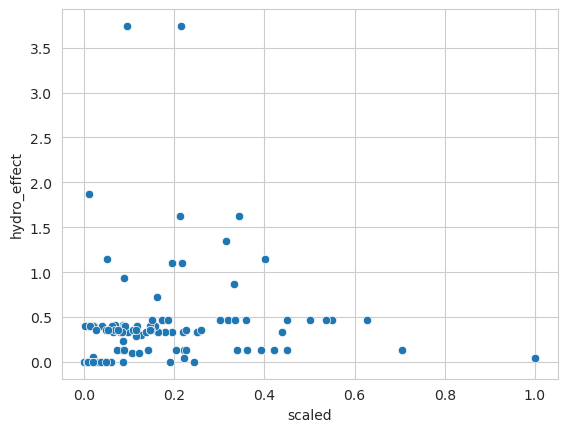

In [86]:
aare_samples = fdx.feature_data[fdx.feature_data.river_bassin == "aare"].copy()
aare_sample_totals = aare_samples[aare_samples.w_t == "l"].groupby(["loc_date", "city", "location"], as_index=False).pcs_m.sum()

def addHydroEffect(x, effected):
    
    if x in effected.index:
        effect = effected.loc[x]
    else:
        effect = 0
    
    return effect

xmin = aare_sample_totals.pcs_m.min()
xmax = aare_sample_totals.pcs_m.max()
aare_sample_totals["scaled"] = aare_sample_totals.pcs_m.apply(lambda x: scaleTheColumn(x, xmin, xmax))
aare_sample_totals["hydro_effect"] = aare_sample_totals.location.map(lambda x: addHydroEffect(x, intersect_effect))
sns.scatterplot(aare_sample_totals, x="scaled", y="hydro_effect")

In [108]:
aare_sample_totals.scaled.corr(aare_sample_totals.hydro_effect)

0.12609172765386825

<AxesSubplot: xlabel='scaled', ylabel='effect'>

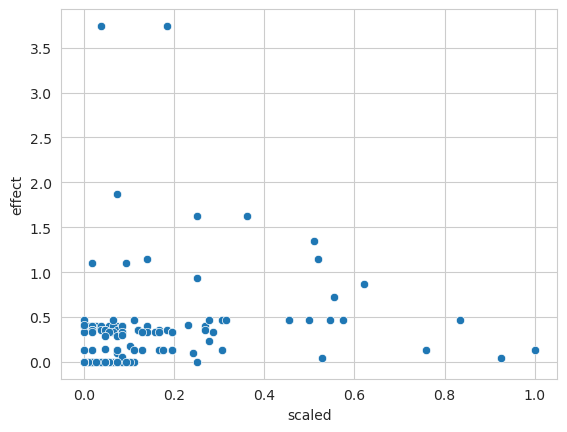

In [105]:
aare_samples["effect"] = aare_samples.location.map(lambda x: addHydroEffect(x, intersect_effect))

code="G30"

test_samples = aare_samples[aare_samples.code == code].copy()

xmin = test_samples.pcs_m.min()
xmax = test_samples.pcs_m.max()
test_samples["scaled"] = test_samples.pcs_m.apply(lambda x: scaleTheColumn(x, xmin, xmax))

sns.scatterplot(data=test_samples, x="scaled", y="effect")

In [107]:
test_samples.scaled.corr(test_samples.effect)

0.18589081161131274

In [58]:
intersections.sort_values(by="effect", ascending=False)

,location,intersect,size,class,OBJVAL,OBJVAL_2,d,scaled,effect
4,pointe-dareuse,L'Areuse,7,7,Seeufer,Fluss,53,0.005271,1.649596
39,sundbach-strand,Sundgraben,9,9,Seeufer,Seeachse,43,0.000000,1.581395
37,sundbach-strand,N_P,9,9,Seeufer,Fluss,43,0.000000,1.581395
108,hafeli,Lütschine,6,6,Seeufer,Fluss,111,0.035846,0.918919
194,wycheley,Kanal Aarboden,18,8,Seeufer,Fluss,86,0.022667,0.889535
...,...,...,...,...,...,...,...,...,...
178,weissenau-neuhaus,Schifffahrtskanal,20,10,Seeufer,Fluss,1410,0.720611,0.043404
36,sundbach-strand,Chrutbach,10,10,Seeufer,Fluss,1445,0.739062,0.042353
80,gals-reserve,Mülibach,10,10,Seeufer,Fluss,1528,0.782815,0.040052
134,la-thiele_le-mujon_confluence,Le Buron,8,8,Seeufer,Seeachse,1932,0.995783,0.039596


## Enquiries

H

1. What are the chances that a survey will exceed the national median for the following values:
   * Sample total
   * Sample total of the most common objects
2. What is the expected range of sample results for the following values:  
   * Sample total
   * Sample total of the most common objects


   

  
